In [1]:
import os, io, shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sampler import MultiSampler
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.handhygiene import HandHygiene
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, ToTensor)
from temporal_transforms import (
    MirrorLoopPadding, LoopPadding, TemporalBeginCrop, 
    TemporalRandomCrop, TemporalCenterCrop, TemporalRandomChoice)
from openpose_transforms import CropTorso, MultiScaleTorsoRandomCrop

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
model_name = 'i3d'
batch_size = 1
clip_len = 16
num_classes = 1

torch.manual_seed(100)
data_name = 'anesthesia'
dataset_path = os.path.join(os.getcwd(), 'data')

In [3]:
scales = 1.0
sample_duration = clip_len
sample_size = 224
mean=[110.63666788, 103.16065604, 96.29023126]
std=[38.7568578, 37.88248729, 40.02898126]

scales=np.linspace(1, 1.75, num=1e4)
openpose_transform = MultiScaleTorsoRandomCrop(scales, sample_size)
spatial_transform = {
    'train': Compose([
            Scale(sample_size),
            CenterCrop(sample_size),
            RandomHorizontalFlip(),
            ColorJitter(brightness=0.1),
            RandomRotation(15),
            ToTensor(1), 
            Normalize(mean, std)]),
    'val': Compose([Scale(sample_size), CenterCrop(sample_size), 
                    ToTensor(1), Normalize(mean, std)])}
temporal_transform = {
    'train': TemporalRandomChoice([
            TemporalBeginCrop(sample_duration),
            TemporalRandomCrop(sample_duration),
            TemporalCenterCrop(sample_duration),
            LoopPadding(sample_duration),
            MirrorLoopPadding(sample_duration)]),
    'val':TemporalCenterCrop(sample_duration)}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


In [4]:
dataset = {
    'train':HandHygiene(dataset_path, split='train', clip_len=clip_len, 
                        spatial_transform=spatial_transform['train'],
                        openpose_transform=openpose_transform,
                        temporal_transform=temporal_transform['train'], num_workers=16),
    'val':HandHygiene(dataset_path, split='val', clip_len=clip_len, 
                        spatial_transform=spatial_transform['val'],
                        temporal_transform=temporal_transform['val'], num_workers=16)}

length = dataset['train'].__len__()
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, sampler=MultiSampler(dataset['train'], length*10), num_workers=16),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, num_workers=16)}

Number of /data/private/minjee-video/handhygiene/data/images/train videos: 91
Number of /data/private/minjee-video/handhygiene/data/images/val videos: 8


In [5]:
from train import get_models
from train import train
from torchsummary import summary

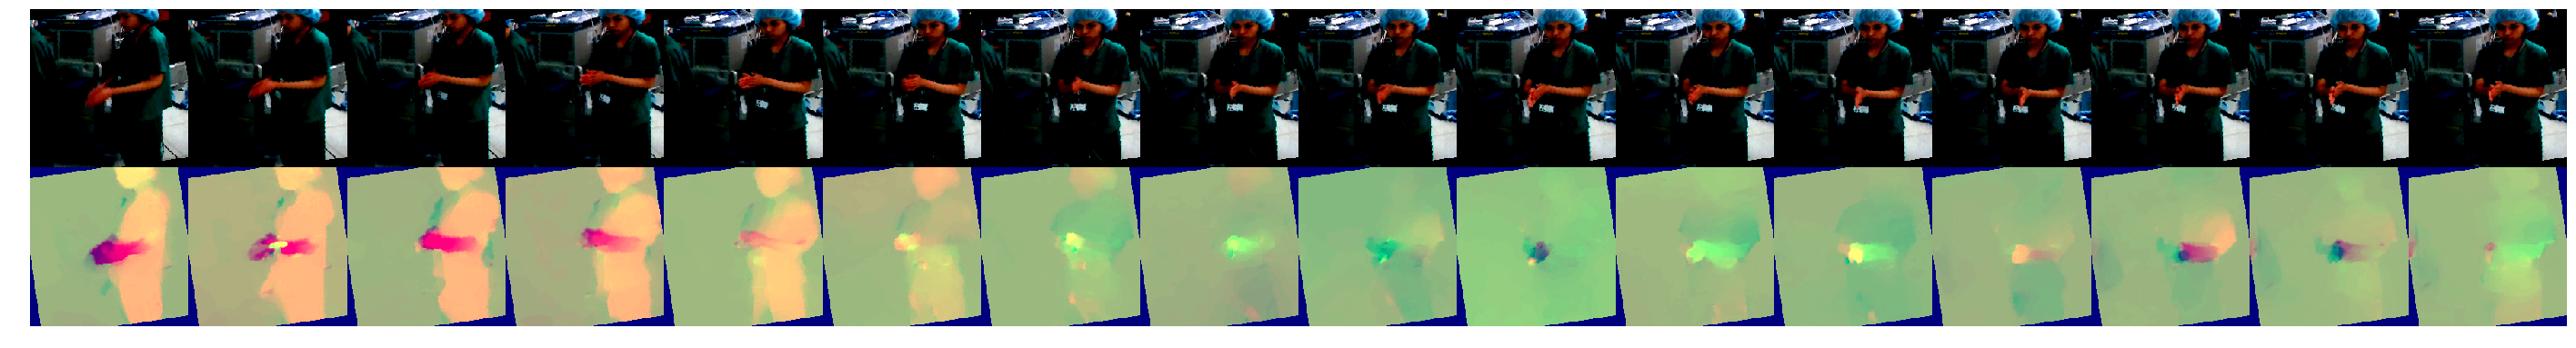

tensor([0])
/data/private/minjee-video/handhygiene/data/images/train/clean/1_20180806_frames001060


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(item[2])

i=0
phase='train'
show_dataset(dataset[phase].__getitem__(i))
print(dataset[phase].__getpath__(i))

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
i3d_rgb, i3d_flow = get_models(num_classes, True, 170) # unfreeze last mix 170, 152
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    i3d_rgb = nn.DataParallel(i3d_rgb)
    i3d_flow = nn.DataParallel(i3d_flow)
i3d_rgb.to(device)
i3d_flow.to(device)

criterion = F.binary_cross_entropy
#criterion = nn.BCELoss
optims={'rgb':None, 'flow':None}
schedulers = {'rgb':None, 'flow':None}
feature_extract=True

Let's use 2 GPUs!


In [13]:
def trainable_params(model, mode='rgb'):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    optims[mode] = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-7)
    schedulers[mode] = lr_scheduler.StepLR(optims[mode], 20, 0.1)
    
trainable_params(i3d_rgb, 'rgb')
trainable_params(i3d_flow, 'flow')

Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias


# summary(i3d_rgb, (3, 64, 224, 224))

In [ ]:
train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=100)

  0%|          | 0/10 [00:00<?, ?it/s]